# Figure 4: Within-host variants are not enriched along branches leading to human infections

June 6, 2019 

If within-host variants are human-adaptive, then we might expect to observe them along the H5N1 phylogeny. Specifically, we would expect that they should occur on branches that lead to human infections. To quantify this, I used the same protocol as described in [Soh et al](https://elifesciences.org/articles/45079).

I used json files from nextstrain.org/flu/avian/h5n1, for each gene in the genome, and converted these jsons to BioPhylo objects. I did not subsample these tips because I wanted to include the maximum possible number of mutations along the tree. I then iterated through the nodes in the tree, from root to tip, and classified mutations along branches as follows: 

**1. Human to human:** If the current clade includes only human sequences, look at its parent node. If all terminal branches stemming from its parent node are human, then the current clade falls within a monophyletic human clade. This branch is labelled "human to human." SNPs on this branch are added to the "human_to_human" list. 

**2. Avian to human:** If the current clade includes only human sequences, look at its parent node. If the terminal branches stemming from its parent node include both human and nonhuman sequences, then the current clade represents the branch leading to a monophyletic human clade. This branch is labelled "avian to human." SNPs on this branch are added to the "bird_to_human" list. 

**3. Avian to avian:** If the current clade includes a mixture of human and nonhuman sequences, the branch leading to that clade is labelled as "avian to avian". Any SNPs that occur along this branch are added to the "bird_to_bird" list. 

**Tree tips** are treated as clades themselves, and are categorized as above. For example, a human tip that falls within a bird clade will have the branch leading to it labelled as bird to human, and those SNPs will be added to the bird_to_human list. A human tip that falls within a human-only clade will have its branch labelled as human to human, and its SNPs will be added to the human_to_human list. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib, csv, json
from subprocess import call
import collections
from collections import Counter
from Bio import SeqIO
from Bio import Seq
import Bio.Phylo
import pandas as pd
import numpy as np
import rpy2
from scipy import stats
%load_ext rpy2.ipython 

In [2]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

In [3]:
# this is to alleviate a strange problem. When running pandas .groupby, it kept freezing the ipython kernel 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Functions for reading jsons and generating BioPhylo tree object 

These functions are copied and pasted directly from nextstrain augur/base/io_util.py

In [4]:
# function to use the json module to read in a json file and store it as "data"                
def read_json(file_name):
    try:
        handle = open(file_name, 'r')
    except IOError:
        pass
    else:
        data = json.load(handle)
        handle.close()
    return data

In [5]:
# original code that Trevor gave me for parsing through tree jsons and returning descendents
def all_descendants(node):
    """Take node, ie. dict, and return a flattened list of all nodes descending from this node"""
    yield node
    
    # this will recursively return all internal nodes (nodes with children)
    if 'children' in node:
        for child in node['children']:
            for desc in all_descendants(child):
                yield desc

In [6]:
# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

In [7]:
def annotate_parents(tree):
    # Get all parent nodes by node.
    parents_by_node = all_parents(tree)

    # Next, annotate each node with its parent.
    for node in tree.find_clades():
        if node == tree.root:
            node.up = None
        else:
            node.up = parents_by_node[node]

    # Return the tree.
    return tree

In [8]:
def json_to_tree(json_dict, root=True):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.

    Assigns links back to parent nodes for the root of the tree.

    >>> import json
    >>> json_fh = open("tests/data/json_tree_to_nexus/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child, root=False) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    node.numdate = node.attr.get("num_date")
    node.branch_length = node.attr.get("div")

    if "translations" in node.attr:
        node.translations = node.attr["translations"]

    if root:
        node = annotate_parents(node)

    return node

## Parse H5N1 trees

This code will loop through each clade in the tree (starting from the root out to the terminal nodes). For each clade, gather all terminal nodes that fall within that clade. If the current clade includes only human sequences, then it will be labelled human to human or bird to human as described above. 

In [9]:
def parse_tree_and_return_muts(tree, gene): 

# lists to store amino acid mutations 
    bird_to_bird = []
    bird_to_human = []
    human_to_human = []

    # loop through all the nodes in the tree, going from root to tip 
    for clade in tree.find_clades(): 
        tips_list = []
        hosts_list = []

        # for each clade, output all terminal nodes that fall within that clade 
        for terminal in clade.get_terminals():
            hosts_list.append(terminal.attr['host'])
            tips_list.append(terminal.name)
        
        # if all terminal nodes are human, print the clade name and the list of terminal branches it entails
        if set(hosts_list) == {'human'}:
            #print(clade, tips_list, hosts_list)
            
            # now check to see if the node above includes terminal nodes that are not human 
            up1_hosts_list = []
            up1_tips_list = []

            # get terminal nodes for the node up one (parent node)
            for x in clade.up.get_terminals():   
                up1_hosts_list.append(x.attr['host'])
                up1_tips_list.append(x.name)

            # if the node above contains not just human samples, then clade should be set to bird_to_human
            if len(set(up1_hosts_list)) > 1 and hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                #print("banana", clade.up, up1_tips_list, up1_hosts_list, set(up1_hosts_list), len(set(up1_hosts_list)))
                if gene in clade.aa_muts:
                    for mut in clade.aa_muts[gene]:
                        bird_to_human.append(mut)

            # if including the node above still gives you an entirely human clade, then add these mutations to the 
            # human to human count 
            elif set(up1_hosts_list) == {'human'} and hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                #print("sloth", clade.up, up1_tips_list, up1_hosts_list,set(up1_hosts_list), len(set(up1_hosts_list)))
                if gene in clade.aa_muts:
                    for mut in clade.aa_muts[gene]:
                        human_to_human.append(mut)

            elif clade.aa_muts == {}:
                pass

            else:
                print('some other option I havent thought of but need to address')
                print(clade.up, up1_tips_list, up1_hosts_list, clade.aa_muts)

        else:
            if hasattr(clade, "aa_muts") and clade.aa_muts != {}:
                if gene in clade.aa_muts:
                    for a in clade.aa_muts[gene]: 
                        bird_to_bird.append(a)
                    
    return(bird_to_bird, bird_to_human, human_to_human)

In [10]:
# print(len(bird_to_bird), len(set(bird_to_bird)), len(bird_to_human), len(set(bird_to_human)), len(human_to_human), len(set(human_to_human)))

### Count the number of times each mutation occurs in each list 

In [11]:
aa_dict = {"A":"Ala","R":"Arg","N":"Asn","D":"Asp","C":"Cys","Q":"Gln","E":"Glu","G":"Gly","H":"His","I":"Ile","L":"Leu","K":"Lys","M":"Met","F":"Phe","P":"Pro","S":"Ser","T":"Thr","W":"Trp","Y":"Tyr","V":"Val", "*":"stop"}

In [12]:
def convert_aa_changes(bb, bh, hh):
    bb2 = []
    bh2 = []
    hh2 = []
    
    for a in bb:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        bb2.append(a)  
    for a in bh:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        bh2.append(a)
    for a in hh:
        # convert aa symbols to 3-letter abbreviations
        first_aa = a[0]
        new_first = aa_dict[first_aa]
        last_aa = a[-1]
        new_last = aa_dict[last_aa]
        a = a.replace(first_aa, new_first)
        a = a.replace(last_aa, new_last)
        hh2.append(a)
        
    return(bb2, bh2, hh2)

In [13]:
def return_SNP_counts(bb, bh, hh):
    
    # use Counter to count the number of times each amino acid change is detected in each list; print total unique SNPs
    bird_to_bird_count = Counter(bird_to_bird)
    bird_to_human_count = Counter(bird_to_human)
    human_to_human_count = Counter(human_to_human)
    #print(len(bird_to_bird_count), len(bird_to_human_count), len(human_to_human_count))
    
    # get a complete list of all of the SNPs identified
    all_SNPs = set(bird_to_human + bird_to_bird + human_to_human)
    
    # loop through and count how many times each SNP occurs in each dataset 
    all_counts = {}

    for a in all_SNPs:
                
        if a in bird_to_bird_count:
            b_to_b = bird_to_bird_count[a]
        else:
            b_to_b = 0

        if a in bird_to_human_count:
            b_to_h = bird_to_human_count[a]
        else:
            b_to_h = 0

        if a in human_to_human_count:
            h_to_h = human_to_human_count[a]   
        else:
            h_to_h = 0


        all_counts[a] = {"bird_to_bird":b_to_b, "bird_to_human": b_to_h, "human_to_human": h_to_h}
    return(all_counts)

In [14]:
def generate_dataframe(all_counts, gene, df):
    df1 = pd.DataFrame.from_dict(all_counts, orient='index')
    df1 = df1.reset_index()
    df1.columns=['coding_region_change','bird_to_bird','bird_to_human','human_to_human']
    df1['gene'] = gene
    df = df.append(df1)
    return(df)

## Loop through all gene trees and run

In [15]:
df = pd.DataFrame()

for f in glob.glob("/Users/lmoncla/src/h5n1-cambodia/data/tree-jsons/flu_avian_h5n1*_tree.json"):
    tree = read_json(f)
    tree = json_to_tree(tree)
    gene = f.split("/")[-1].split("_")[3].upper()
        
    if gene != "MP" and gene != "NS":
        # run everything
        bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, gene)
        #bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
        all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
        df = generate_dataframe(all_counts, gene, df)
        
    elif gene == "MP":
        genes = ["M1","M2"]
        for g in genes: 
            bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, g)
            #bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
            all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
            df = generate_dataframe(all_counts, g, df)
    
    elif gene == "NS":
        genes = ["NS1","NS2"]
        for g in genes: 
            bird_to_bird, bird_to_human, human_to_human = parse_tree_and_return_muts(tree, g)
            #bird_to_bird, bird_to_human, human_to_human = convert_aa_changes(bird_to_bird, bird_to_human, human_to_human)
            all_counts = return_SNP_counts(bird_to_bird, bird_to_human, human_to_human)
            df = generate_dataframe(all_counts, g, df)

In [16]:
df['gene'] = df['gene'].fillna("NA")
df['site'] = df['gene'] + " " + df['coding_region_change']
df.head()

,coding_region_change,bird_to_bird,bird_to_human,human_to_human,gene,site
0,*569K,22,1,6,HA,HA *569K
1,*569R,2,0,0,HA,HA *569R
2,*569S,1,0,0,HA,HA *569S
3,*569Y,0,1,0,HA,HA *569Y
4,A102D,2,0,0,HA,HA A102D


In [17]:
# test to make sure this is working as it should
sloth = df[df['site'] == 'PB2 E627K']
sloth

,coding_region_change,bird_to_bird,bird_to_human,human_to_human,gene,site
251,E627K,15,28,8,PB2,PB2 E627K


## Read in within-host SNP calls

In [18]:
within_host= "/Users/lmoncla/src/h5n1-cambodia/data/within-host-variants-1%.tsv"
wh = pd.DataFrame.from_csv(within_host, sep="\t")
wh.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
sampleid,,,,,,,,,,
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [19]:
# fix NA misread as nan
wh['gene'] = wh['gene'].fillna("NA")

#subset to just nonsynonymous changes 
wh = wh.loc[wh['synonymous_nonsynonymous'] == 'nonsynonymous']
wh = wh.loc[wh['coding_region_change'] != 'Xaa240Gly']
wh.head()

,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
sampleid,,,,,,,,,,
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB1,A/duck/Cambodia/381W11M4/2013,PB1,968,A,G,Met317Val,nonsynonymous,4.21%,0.0421,NaN
AJJ9KL707F511_A_duck_Cambodia_PV027D1_2010_MP,A/duck/Cambodia/PV027D1/2010,M1,621,C,T,Ala199Val,nonsynonymous,4.56%,0.0456,NaN


In [20]:
aa_dict2 = {"Ala":"A","Arg":"R","Asn":"N","Asp":"D","Cys":"C","Gln":"N","Glu":"E","Gly":"G","His":"H","Ile":"I",
           "Leu":"L","Lys":"K","Met":"M","Phe":"F","Pro":"P","Ser":"S","Thr":"T","Trp":"W","Tyr":"Y","Val":"V",
           "stop":"*"}

sites2 = []
for i in wh['coding_region_change']:
    wt_aa = aa_dict2[i[0:3]]
    variant_aa = aa_dict2[i[-3:]]
    aa = i[3:-3]
    new_site = wt_aa+aa+variant_aa
    sites2.append(new_site)

wh['coding_region_change'] = sites2
wh.head()

,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
sampleid,,,,,,,,,,
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,A265T,nonsynonymous,3.28%,0.0328,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,N117R,nonsynonymous,20.43%,0.2043,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,R367K,nonsynonymous,19%,0.1900,NaN
AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB1,A/duck/Cambodia/381W11M4/2013,PB1,968,A,G,M317V,nonsynonymous,4.21%,0.0421,NaN
AJJ9KL707F511_A_duck_Cambodia_PV027D1_2010_MP,A/duck/Cambodia/PV027D1/2010,M1,621,C,T,A199V,nonsynonymous,4.56%,0.0456,NaN


In [21]:
# add in a species column
wh['originating_species'] = wh['sample'].str.contains("duck", "duck")
wh['originating_species'] = wh['originating_species'].replace(True,"duck")
wh['originating_species'] = wh['originating_species'].replace(False,"human")
wh.reset_index(inplace=True)

# subset down to just coding region change and originating species 
wh = wh[['coding_region_change','originating_species','gene']]
wh['site'] = wh['gene'] + " " + wh['coding_region_change']
wh.head()

,coding_region_change,originating_species,gene,site
0,A265T,duck,HA,HA A265T
1,N117R,duck,NP,NP N117R
2,R367K,duck,PA,PA R367K
3,M317V,duck,PB1,PB1 M317V
4,A199V,duck,M1,M1 A199V


## Merge within-host dataframe with tree transitions counts dataframe 

In [22]:
merged = pd.DataFrame(wh[['coding_region_change','gene','originating_species', 'site']]).merge(df, how="left", on=['site','coding_region_change','gene'])
merged = merged.drop_duplicates()
merged['gene'] = merged['gene'].fillna("NA")
merged = merged.fillna(0)
merged.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human
0,A265T,HA,duck,HA A265T,5.0,0.0,0.0
1,N117R,NP,duck,NP N117R,0.0,0.0,0.0
2,R367K,PA,duck,PA R367K,16.0,2.0,1.0
3,M317V,PB1,duck,PB1 M317V,22.0,0.0,0.0
4,A199V,M1,duck,M1 A199V,1.0,0.0,0.0


In [23]:
sloth = merged[merged['site'] == 'HA N198S']
sloth

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human
55,N198S,HA,human,HA N198S,4.0,3.0,0.0


In [24]:
# split site into gene and location 
merged['site2'] = merged.coding_region_change.str[1:]

# sort 
merged['gene'] = pd.Categorical(merged['gene'], ['PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP'])
merged = merged.sort_values(by=['originating_species','gene', 'site2'])
merged.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,site2
3,M317V,PB1,duck,PB1 M317V,22.0,0.0,0.0,317V
2,R367K,PA,duck,PA R367K,16.0,2.0,1.0,367K
5,K129E,HA,duck,HA K129E,1.0,0.0,0.0,129E
0,A265T,HA,duck,HA A265T,5.0,0.0,0.0,265T
12,V363I,HA,duck,HA V363I,0.0,0.0,0.0,363I


In [25]:
# get the order that I want these plotted in 
duck_merged = merged[merged['originating_species'] == "duck"]
human_merged = merged[merged['originating_species'] == "human"]
duck_order = duck_merged['site'].tolist()
human_order = human_merged['site'].tolist()
print(duck_order)
print(human_order)

['PB1 M317V', 'PA R367K', 'HA K129E', 'HA A265T', 'HA V363I', 'NP N117R', 'NP S170L', 'NP T188I', 'NP T215I', 'NP A403V', 'NA K58E', 'M1 A199V', 'NS1 L207P', 'NS1 P210S', 'NEP F55L']
['PB2 H151P', 'PB2 E165V', 'PB2 N348Y', 'PB2 N392H', 'PB2 S532P', 'PB2 N540S', 'PB2 P579S', 'PB2 V584A', 'PB2 I616T', 'PB2 E627K', 'PB2 V667I', 'PB2 M66T', 'PB2 D678V', 'PB2 N701D', 'PB2 S714G', 'PB2 V724E', 'PB1 A144V', 'PB1 R211G', 'PB1 K265R', 'PB1 K353R', 'PB1 K379R', 'PB1 I389V', 'PB1 I484M', 'PB1 T566S', 'PB1 L589P', 'PB1 G71E', 'PB1 D76N', 'PA R142K', 'PA T157N', 'PA A169T', 'PA K237E', 'PA K318E', 'PA N359T', 'PA F35S', 'PA D426E', 'PA V432I', 'PA N466H', 'PA I505M', 'PA N568S', 'PA L589P', 'PA E610G', 'PA K615R', 'PA S631G', 'PA S659P', 'PA P68L', 'PA T85A', 'HA H141R', 'HA E142G', 'HA A150V', 'HA L166P', 'HA K172T', 'HA Y173H', 'HA I176T', 'HA P197L', 'HA N198S', 'HA P210T', 'HA N222D', 'HA T226A', 'HA R232G', 'HA R232K', 'HA N238L', 'HA N238R', 'HA N252D', 'HA N262D', 'HA F307L', 'HA V322A', 'HA

In [26]:
len(merged)

120

In [27]:
# add in end in human column and site column; fix NA getting read as an NaN
merged['end_in_human'] = merged['bird_to_human'] + merged['human_to_human']
merged.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,site2,end_in_human
3,M317V,PB1,duck,PB1 M317V,22.0,0.0,0.0,317V,0.0
2,R367K,PA,duck,PA R367K,16.0,2.0,1.0,367K,3.0
5,K129E,HA,duck,HA K129E,1.0,0.0,0.0,129E,0.0
0,A265T,HA,duck,HA A265T,5.0,0.0,0.0,265T,0.0
12,V363I,HA,duck,HA V363I,0.0,0.0,0.0,363I,0.0


In [28]:
# remove the within-host SNPs that weren't found in the tree at all 
in_tree = merged[(merged['bird_to_bird'] + merged['end_in_human']) > 0]
len(in_tree), len(merged)

(60, 120)

In [30]:
# melt dataframe for plotting 
melted = in_tree.melt(value_vars=['bird_to_bird','end_in_human'], id_vars=['originating_species','site'])
melted = melted.sort_values(by=['site'])
melted.head()

,originating_species,site,variable,value
37,human,HA A150V,bird_to_bird,1.0
97,human,HA A150V,end_in_human,8.0
3,duck,HA A265T,bird_to_bird,5.0
63,duck,HA A265T,end_in_human,0.0
36,human,HA E142G,bird_to_bird,3.0


In [31]:
human_melted = melted[melted['originating_species'] == "human"]
duck_melted = melted[melted['originating_species'] == "duck"]
duck_melted.head()

,originating_species,site,variable,value
3,duck,HA A265T,bird_to_bird,5.0
63,duck,HA A265T,end_in_human,0.0
2,duck,HA K129E,bird_to_bird,1.0
62,duck,HA K129E,end_in_human,0.0
4,duck,M1 A199V,bird_to_bird,1.0


# Perform Fisher's exact tests 

We would like to know which within-host mutations are stastically enriched along transitions leading to humans. We will perform Fisher's exact tests comparing the overall proportion of bird to bird vs. end in human transitions along the tree, vs. the proportions for individual mutatations. 

In [32]:
# first compute how many total bird to bird and bird to human/human to human transitions there are along the tree 
# df is the dataframe with the transition counts along the tree
total_bird_bird = df['bird_to_bird'].sum()
total_end_in_human = df['bird_to_human'].sum() + df['human_to_human'].sum()
print(total_bird_bird, total_end_in_human)

31939 2787


In [33]:
# in_tree is the dataframe with within-host information and individual mutation tree transition counts for all the 
# within-host variants that were detected in the tree
in_tree.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,site2,end_in_human
3,M317V,PB1,duck,PB1 M317V,22.0,0.0,0.0,317V,0.0
2,R367K,PA,duck,PA R367K,16.0,2.0,1.0,367K,3.0
5,K129E,HA,duck,HA K129E,1.0,0.0,0.0,129E,0.0
0,A265T,HA,duck,HA A265T,5.0,0.0,0.0,265T,0.0
4,A199V,M1,duck,M1 A199V,1.0,0.0,0.0,199V,0.0


In [34]:
# run a Fisher's exact test with scipy; this returns (odds ratio, p-value)
# table = [bird to bird transitions total, end in human transitions total]
        # [bird to bird transitions for mutant, end in human transitions for mutant]
table = [[31939,2787],[22,0]]
stats.fisher_exact(table)

(0.0, 0.2535338785236507)

In [35]:
# now run on actual data
p_values = {}

for index, row in in_tree.iterrows():
    mutation = row['coding_region_change']
    bird_to_bird = row['bird_to_bird']
    end_in_human = row['end_in_human']
    
    table = [[31939,2787],[bird_to_bird,end_in_human]]
    p_value = (stats.fisher_exact(table))[1]
        
    if p_value < 0.05:
        print(mutation, p_value)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values[mutation] = {"p_value":p_value, "significance":significance}

E627K 4.206727552660999e-28
A150V 1.4554994489395264e-08
N198S 0.014161436706657687


In [36]:
# add p-values to dataframe for plotting
x = pd.DataFrame.from_dict(p_values, orient="index")
x = x.reset_index()
x.columns = ['coding_region_change','p_value','significance']
x.head()

,coding_region_change,p_value,significance
0,A150V,1.455499e-08,****
1,A199V,1.000000e+00,
2,A227T,6.337857e-01,
3,A265T,1.000000e+00,
4,C50Y,1.000000e+00,


In [37]:
# merge 
in_tree2 = in_tree.merge(x, on="coding_region_change")
in_tree2.head()

,coding_region_change,gene,originating_species,site,bird_to_bird,bird_to_human,human_to_human,site2,end_in_human,p_value,significance
0,M317V,PB1,duck,PB1 M317V,22.0,0.0,0.0,317V,0.0,0.253534,
1,R367K,PA,duck,PA R367K,16.0,2.0,1.0,367K,3.0,0.192267,
2,K129E,HA,duck,HA K129E,1.0,0.0,0.0,129E,0.0,1.000000,
3,A265T,HA,duck,HA A265T,5.0,0.0,0.0,265T,0.0,1.000000,
4,A199V,M1,duck,M1 A199V,1.0,0.0,0.0,199V,0.0,1.000000,


In [38]:
sig_df = in_tree2[['site','significance','originating_species','bird_to_bird','end_in_human']]
sig_df['height'] = sig_df['bird_to_bird'] + sig_df['end_in_human']
sig_df['variable'] = "human/bird to human"

sig_df_duck = sig_df[sig_df['originating_species'] == 'duck']
sig_df_human = sig_df[sig_df['originating_species'] == 'human']

sig_df_human.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,site,significance,originating_species,bird_to_bird,end_in_human,height,variable
5,PB2 H151P,,human,2.0,0.0,2.0,human/bird to human
6,PB2 S532P,,human,3.0,0.0,3.0,human/bird to human
7,PB2 N540S,,human,2.0,0.0,2.0,human/bird to human
8,PB2 P579S,,human,1.0,0.0,1.0,human/bird to human
9,PB2 E627K,****,human,15.0,36.0,51.0,human/bird to human


In [39]:
# melt dataframe for plotting 
melted2 = in_tree2.melt(value_vars=['bird_to_bird','end_in_human'], id_vars=['originating_species','site','significance'])
melted2 = melted2.sort_values(by=['site'])
melted2.head()

,originating_species,site,significance,variable,value
37,human,HA A150V,****,bird_to_bird,1.0
97,human,HA A150V,****,end_in_human,8.0
3,duck,HA A265T,,bird_to_bird,5.0
63,duck,HA A265T,,end_in_human,0.0
36,human,HA E142G,,bird_to_bird,3.0


In [40]:
human_melted2 = melted2[melted2['originating_species'] == "human"]
duck_melted2 = melted2[melted2['originating_species'] == "duck"]
human_melted2.head()

,originating_species,site,significance,variable,value
37,human,HA A150V,****,bird_to_bird,1.0
97,human,HA A150V,****,end_in_human,8.0
36,human,HA E142G,,bird_to_bird,3.0
96,human,HA E142G,,end_in_human,1.0
48,human,HA E91G,,bird_to_bird,1.0


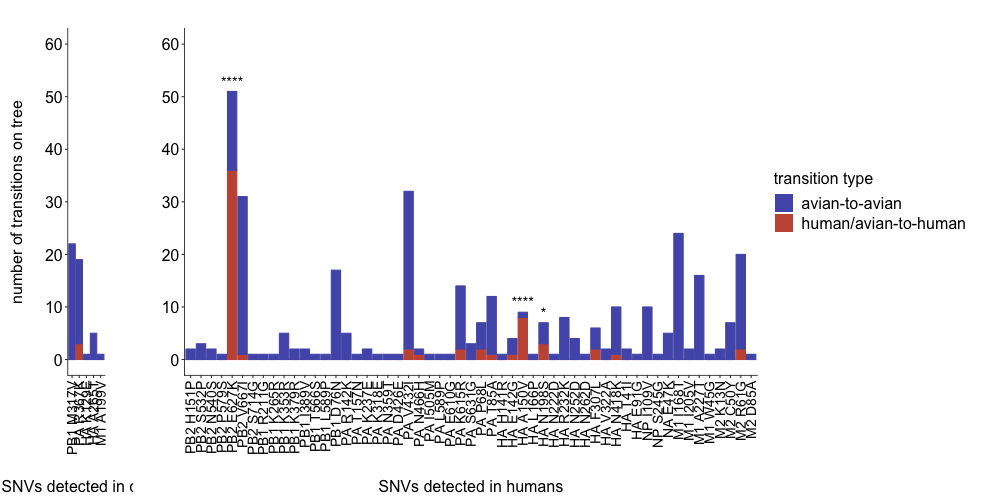

In [42]:
%%R -w 1000 -h 500 -u px -i duck_melted2,human_melted2,sig_df_human,sig_df_duck,human_color,duck_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

# this is to make sure that they plot in order
duck_melted2$sitef = factor(duck_melted2$site, levels=c('PB1 M317V', 'PA R367K', 'HA K129E', 'HA A265T', 'HA V363I', 'NP N117R', 'NP S170L', 'NP T188I', 'NP T215I', 'NP A403V', 'NA K58E', 'M1 A199V', 'NS1 L207P', 'NS1 P210S', 'NEP F55L'))
human_melted2$sitef = factor(human_melted2$site, levels=c('PB2 H151P', 'PB2 E165V', 'PB2 N348Y', 'PB2 N392H', 'PB2 S532P', 'PB2 N540S', 'PB2 P579S', 'PB2 V584A', 'PB2 I616T', 'PB2 E627K', 'PB2 V667I', 'PB2 M66T', 'PB2 D678V', 'PB2 N701D', 'PB2 S714G', 'PB2 V724E', 'PB1 A144V', 'PB1 R211G', 'PB1 K265R', 'PB1 K353R', 'PB1 K379R', 'PB1 I389V', 'PB1 I484M', 'PB1 T566S', 'PB1 L589P', 'PB1 G71E', 'PB1 D76N', 'PA R142K', 'PA T157N', 'PA A169T', 'PA K237E', 'PA K318E', 'PA N359T', 'PA F35S', 'PA D426E', 'PA V432I', 'PA N466H', 'PA I505M', 'PA N568S', 'PA L589P', 'PA E610G', 'PA K615R', 'PA S631G', 'PA S659P', 'PA P68L', 'PA T85A', 'HA H141R', 'HA E142G', 'HA A150V', 'HA L166P', 'HA K172T', 'HA Y173H', 'HA I176T', 'HA P197L', 'HA N198S', 'HA P210T', 'HA N222D', 'HA T226A', 'HA R232G', 'HA R232K', 'HA N238L', 'HA N238R', 'HA N252D', 'HA N262D', 'HA F307L', 'HA V322A', 'HA N418K', 'HA T41I', 'HA Y503C', 'HA E91G', 'NP L108P', 'NP I109V', 'NP L166V', 'NP E220G', 'NP I225T', 'NP S245G', 'NP R246G', 'NP A260V', 'NP R267G', 'NP R98N', 'NA H106N', 'NA P149R', 'NA V214I', 'NA C270S', 'NA S344G', 'NA S344N', 'NA M353V', 'NA T418A', 'NA E47K', 'M1 I168T', 'M1 R178G', 'M1 G185D', 'M1 I205V', 'M1 A227T', 'M1 N26R', 'M1 D30N', 'M1 W45G', 'M2 P10R', 'M2 K13N', 'M2 C50Y', 'M2 R61G', 'M2 D85A', 'NS1 P159L', 'NEP S24L', 'NEP E47G'))
sig_df_duck$sitef = factor(sig_df_duck$site, levels=c('PB1 M317V', 'PA R367K', 'HA K129E', 'HA A265T', 'HA V363I', 'NP N117R', 'NP S170L', 'NP T188I', 'NP T215I', 'NP A403V', 'NA K58E', 'M1 A199V', 'NS1 L207P', 'NS1 P210S', 'NEP F55L'))
sig_df_human$sitef = factor(sig_df_human$site, levels=c('PB2 H151P', 'PB2 E165V', 'PB2 N348Y', 'PB2 N392H', 'PB2 S532P', 'PB2 N540S', 'PB2 P579S', 'PB2 V584A', 'PB2 I616T', 'PB2 E627K', 'PB2 V667I', 'PB2 M66T', 'PB2 D678V', 'PB2 N701D', 'PB2 S714G', 'PB2 V724E', 'PB1 A144V', 'PB1 R211G', 'PB1 K265R', 'PB1 K353R', 'PB1 K379R', 'PB1 I389V', 'PB1 I484M', 'PB1 T566S', 'PB1 L589P', 'PB1 G71E', 'PB1 D76N', 'PA R142K', 'PA T157N', 'PA A169T', 'PA K237E', 'PA K318E', 'PA N359T', 'PA F35S', 'PA D426E', 'PA V432I', 'PA N466H', 'PA I505M', 'PA N568S', 'PA L589P', 'PA E610G', 'PA K615R', 'PA S631G', 'PA S659P', 'PA P68L', 'PA T85A', 'HA H141R', 'HA E142G', 'HA A150V', 'HA L166P', 'HA K172T', 'HA Y173H', 'HA I176T', 'HA P197L', 'HA N198S', 'HA P210T', 'HA N222D', 'HA T226A', 'HA R232G', 'HA R232K', 'HA N238L', 'HA N238R', 'HA N252D', 'HA N262D', 'HA F307L', 'HA V322A', 'HA N418K', 'HA T41I', 'HA Y503C', 'HA E91G', 'NP L108P', 'NP I109V', 'NP L166V', 'NP E220G', 'NP I225T', 'NP S245G', 'NP R246G', 'NP A260V', 'NP R267G', 'NP R98N', 'NA H106N', 'NA P149R', 'NA V214I', 'NA C270S', 'NA S344G', 'NA S344N', 'NA M353V', 'NA T418A', 'NA E47K', 'M1 I168T', 'M1 R178G', 'M1 G185D', 'M1 I205V', 'M1 A227T', 'M1 N26R', 'M1 D30N', 'M1 W45G', 'M2 P10R', 'M2 K13N', 'M2 C50Y', 'M2 R61G', 'M2 D85A', 'NS1 P159L', 'NEP S24L', 'NEP E47G'))


left.plot <- ggplot(data=duck_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    geom_text(data=sig_df_duck, aes(x=sitef, y=height+2, label=significance), size=5, color="black")+
    labs(x = "SNVs detected in ducks", y="number of transitions on tree")+
    scale_color_manual(values=c(bird_to_bird=duck_color,end_in_human=human_color, "black"), guide=FALSE)+
    scale_fill_manual(values=c(bird_to_bird=duck_color,end_in_human=human_color, "black"), guide=FALSE)+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,60), breaks=seq(0,60,10))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

right.plot <- ggplot(data=human_melted2, aes(x=sitef, y=value, color=variable, fill=variable)) + 
    geom_col(position="stack")+
    geom_text(data=sig_df_human, aes(x=sitef, y=height+2, label=significance), size=5, color="black")+
    labs(x = "SNVs detected in humans")+
    scale_color_manual(values=c(bird_to_bird=duck_color,end_in_human=human_color, "black"), guide=FALSE)+
    scale_fill_manual(values=c(bird_to_bird=duck_color,end_in_human=human_color, "black"), breaks=c("bird_to_bird", "end_in_human"),labels=c("avian-to-avian", "human/avian-to-human"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_y_continuous(limits=c(0,60), breaks=seq(0,60,10))+
    labs(fill = "transition type") +
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_blank())+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=14, angle=90, vjust=0.5, hjust = 1))+  #
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(left.plot, right.plot, ncol=2, widths=c(1,6.5))
ggsave("Figure-4-tree-transitions-2019-06-04.pdf", p2, width = 19, height = 5,path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-06-04/individual-PDFs")
